In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Union


In [2]:
# Data loading
# ===========
print("Loading market data...")
try:
    df = pd.read_csv("data/data.csv", sep=";").replace("#N/A N/A", np.nan)
    df = df.iloc[1:].reset_index(drop=True)
    df = df.set_index(df['Dates'])
    df.drop(columns='Dates', inplace=True)
    df.index = pd.to_datetime(df.index, format="%d/%m/%Y")
    df = df.loc[df.index > pd.to_datetime("2018-01-01")]
    
    symbol_col = [" ".join(c.split(" ")[:3]) for c in df.columns if "Equity" in c]
    corrected_columns = []
    for c in range(len(df.columns)):
        if c <= 2:
            corrected_columns.append(df.columns[c])
        else:
            if c % 2 == 1:
                corrected_columns.append(df.columns[c] + " Price")
            else:
                corrected_columns.append(" ".join(corrected_columns[-1].split(" ")[:3]) + " Vol")
    df.columns = corrected_columns
    df = df.astype(float)
    
    print("Available columns:", df.columns.tolist())
    
    stock_columns = [col for col in df.columns if "Equity Price" in col]
    if not stock_columns:
        raise ValueError("No stock price columns found")
        
    stock_ticker = stock_columns[0].split(" Equity")[0].strip()
    price_col = f"{stock_ticker} Equity Price"
    vol_col = f"{stock_ticker} Equity Vol"
    
    print(f"Selected stock: {stock_ticker}")
    print(f"Price column: {price_col}")
    print(f"Volatility column: {vol_col}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Using sample data for testing")
    
    dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='B')
    df = pd.DataFrame(index=dates)
    
    # Sample columns
    stock_ticker = "SAMPLE"
    price_col = f"{stock_ticker} Equity Price"
    vol_col = f"{stock_ticker} Equity Vol"
    
    df["USGG2YR Index"] = 0.05  # 5% interest rate
    
    initial_price = 100
    price_changes = np.random.normal(0, 1, len(dates))
    prices = initial_price * np.exp(np.cumsum(price_changes) * 0.01)
    df[price_col] = prices
    
    df[vol_col] = 20 + np.sin(np.linspace(0, 8*np.pi, len(dates))) * 5  # 15-25% volatility with cyclical pattern


Loading market data...
Available columns: ['USGG2YR Index', 'ES1 Index', 'SX5E Index', 'DG FP Equity Price', 'DG FP Equity Vol', 'TTE FP Equity Price', 'TTE FP Equity Vol', 'AI FP Equity Price', 'AI FP Equity Vol', 'EL FP Equity Price', 'EL FP Equity Vol', 'AIR FP Equity Price', 'AIR FP Equity Vol', 'CS FP Equity Price', 'CS FP Equity Vol', 'CAP FP Equity Price', 'CAP FP Equity Vol', 'SGO FP Equity Price', 'SGO FP Equity Vol', 'HENKEL HB Equity Price', 'HENKEL HB Equity Vol', 'ML FP Equity Price', 'ML FP Equity Vol', 'MC FP Equity Price', 'MC FP Equity Vol', 'ORA FP Equity Price', 'ORA FP Equity Vol', 'SU FP Equity Price', 'SU FP Equity Vol', 'SAN FP Equity Price', 'SAN FP Equity Vol', 'PUB FP Equity Price', 'PUB FP Equity Vol', 'TE FP Equity Price', 'TE FP Equity Vol', 'NESN SW Equity Price', 'NESN SW Equity Vol', 'GE US Equity Price', 'GE US Equity Vol', 'AAPL US Equity Price', 'AAPL US Equity Vol']
Selected stock: DG FP
Price column: DG FP Equity Price
Volatility column: DG FP Equit

Running strategy comparison from 2019-01-01 00:00:00 to 2025-02-21 00:00:00...
Testing Straddle (Unhedged)...
Testing Straddle with Delta Hedge...
Testing Straddle with OTM Put Hedge...
Testing Strangle (Unhedged)...
Testing Strangle with Delta Hedge...
Testing Strangle with OTM Put Hedge...

Strategy Performance Comparison:
                             Total Return  Annual Return  Volatility  \
Straddle (Unhedged)                  0.31           0.05        0.02   
Straddle with Delta Hedge            0.22           0.03        0.05   
Straddle with OTM Put Hedge          0.31           0.05        0.02   
Strangle (Unhedged)                  0.11           0.02        0.01   
Strangle with Delta Hedge            0.03           0.00        0.04   
Strangle with OTM Put Hedge          0.10           0.02        0.01   

                             Sharpe Ratio  Max Drawdown  
Straddle (Unhedged)                  2.25         -0.02  
Straddle with Delta Hedge            0.71         -0

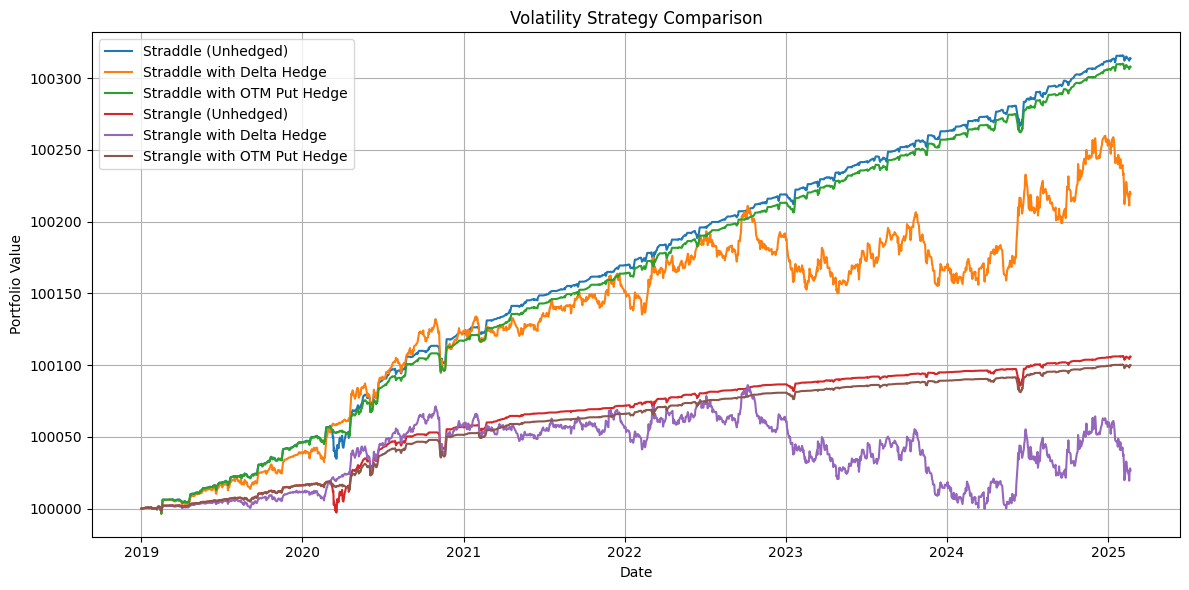

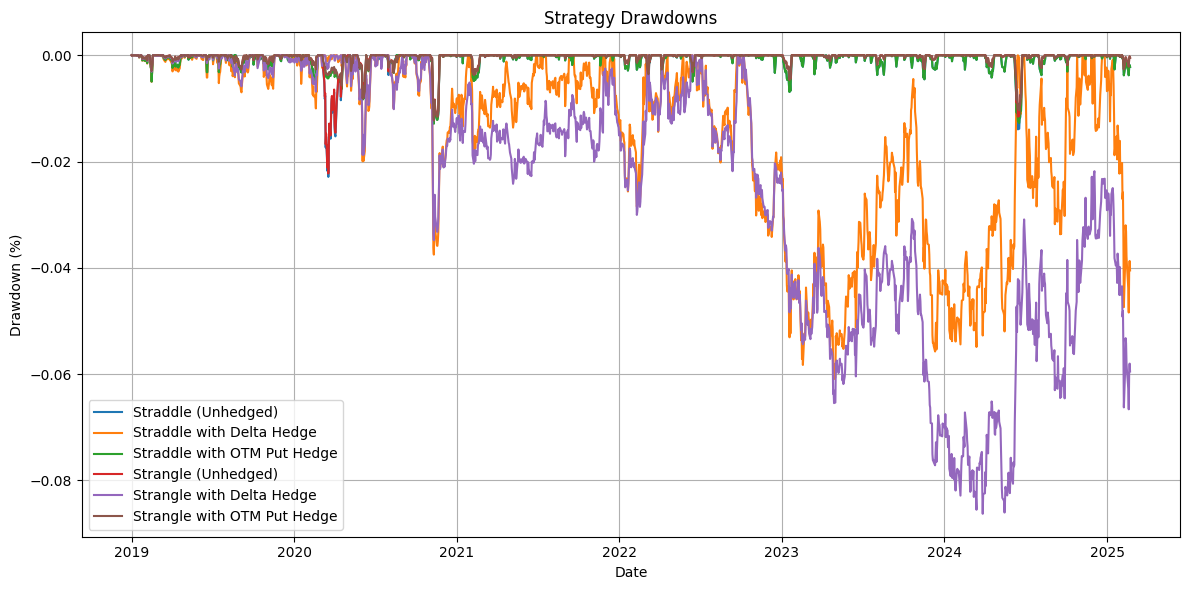


Test completed!


In [4]:

@dataclass
class OptionPosition:
    """Class for tracking option positions"""
    date: datetime
    expiry: datetime
    strike: float
    option_type: str  # 'call' or 'put'
    action: str  # 'long' or 'short'
    quantity: int
    entry_price: float
    underlying_price: float
    iv: float
    r: float
    ttm: float  # time to maturity in years
    
    def __post_init__(self):
        """Calculate additional metrics after initialization"""
        self.entry_value = self.entry_price * self.quantity
        self.direction = 1 if self.action == 'long' else -1

@dataclass
class HedgePosition:
    """Class for tracking hedge positions"""
    date: datetime
    underlying_price: float
    quantity: float
    action: str  # 'long' or 'short'
    
    def __post_init__(self):
        """Calculate position value"""
        self.entry_value = self.underlying_price * self.quantity
        self.direction = 1 if self.action == 'long' else -1


class BSPricer:
    """A simple Black-Scholes option pricer"""
    
    @staticmethod
    def d1(S, K, T, r, sigma):
        return (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    @staticmethod
    def d2(S, K, T, r, sigma):
        return BSPricer.d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
    @staticmethod
    def normal_cdf(x):
        return (1.0 + np.math.erf(x / np.sqrt(2.0))) / 2.0
    
    @staticmethod
    def price_call(S, K, T, r, sigma):
        if T <= 0:
            return max(0, S - K)
        d1 = BSPricer.d1(S, K, T, r, sigma)
        d2 = BSPricer.d2(S, K, T, r, sigma)
        return S * BSPricer.normal_cdf(d1) - K * np.exp(-r * T) * BSPricer.normal_cdf(d2)
    
    @staticmethod
    def price_put(S, K, T, r, sigma):
        if T <= 0:
            return max(0, K - S)
        d1 = BSPricer.d1(S, K, T, r, sigma)
        d2 = BSPricer.d2(S, K, T, r, sigma)
        return K * np.exp(-r * T) * BSPricer.normal_cdf(-d2) - S * BSPricer.normal_cdf(-d1)
    
    @staticmethod
    def price_option(S, K, T, r, sigma, option_type):
        if option_type.lower() == 'call':
            return BSPricer.price_call(S, K, T, r, sigma)
        elif option_type.lower() == 'put':
            return BSPricer.price_put(S, K, T, r, sigma)
        else:
            raise ValueError(f"Invalid option type: {option_type}")
    
    @staticmethod
    def delta_call(S, K, T, r, sigma):
        if T <= 0:
            return 1.0 if S > K else 0.0
        d1 = BSPricer.d1(S, K, T, r, sigma)
        return BSPricer.normal_cdf(d1)
    
    @staticmethod
    def delta_put(S, K, T, r, sigma):
        if T <= 0:
            return -1.0 if S < K else 0.0
        d1 = BSPricer.d1(S, K, T, r, sigma)
        return BSPricer.normal_cdf(d1) - 1
    
    @staticmethod
    def compute_delta(S, K, T, r, sigma, option_type):
        if option_type.lower() == 'call':
            return BSPricer.delta_call(S, K, T, r, sigma)
        elif option_type.lower() == 'put':
            return BSPricer.delta_put(S, K, T, r, sigma)
        else:
            raise ValueError(f"Invalid option type: {option_type}")


class VolatilityStrategy:
    """Class to implement and test volatility selling strategies"""
    
    def __init__(self, df, price_col, vol_col, rate_col='USGG2YR Index', 
                 initial_capital=10000.0, commission=0.0035):
        """
        Initialize the strategy
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame with price, volatility and interest rate data
        price_col : str
            Column name for price data
        vol_col : str
            Column name for implied volatility data
        rate_col : str
            Column name for interest rate data
        initial_capital : float
            Initial capital
        commission : float
            Commission as a percentage of transaction value
        """
        self.df = df.copy()
        self.price_col = price_col
        self.vol_col = vol_col
        self.rate_col = rate_col
        self.initial_capital = initial_capital
        self.commission = commission
        
        # Prepare data
        self.df['price'] = self.df[price_col]
        self.df['iv'] = self.df[vol_col] / 100  # Convert percentage to decimal
        self.df['r'] = self.df[rate_col] / 100   # Convert percentage to decimal
        
        # Reset for each backtest
        self.reset()
        
    def reset(self):
        """Reset the strategy for a new backtest"""
        self.cash = self.initial_capital
        self.positions = []
        self.hedge_positions = []
        self.trades = []
        self.daily_portfolio_values = {}
        self.trade_history = []
        
    def get_third_friday(self, date, months_ahead=1):
        """Find the third Friday of a future month"""
        # Move to the target month
        target_month = date.month + months_ahead
        target_year = date.year + (target_month - 1) // 12
        target_month = ((target_month - 1) % 12) + 1
        
        # Find the first day of the target month
        first_day = datetime(target_year, target_month, 1)
        
        # Find the first Friday
        days_until_friday = (4 - first_day.weekday()) % 7
        first_friday = first_day + timedelta(days=days_until_friday)
        
        # Get the third Friday
        third_friday = first_friday + timedelta(days=14)
        
        return pd.Timestamp(third_friday)
    
    def create_straddle(self, date, expiry, quantity=1, hedge=False, hedge_ratio=None):
        """
        Create a short straddle (ATM call + ATM put)
        
        Parameters:
        -----------
        date : datetime
            Trade date
        expiry : datetime
            Option expiry date
        quantity : int
            Number of contracts
        hedge : bool
            Whether to hedge with the underlying
        hedge_ratio : float or None
            Override the delta-based hedge ratio with a fixed value
        
        Returns:
        --------
        tuple
            (call_position, put_position, hedge_position or None)
        """
        S = self.df.loc[date, 'price']
        iv = self.df.loc[date, 'iv']
        r = self.df.loc[date, 'r']
        
        # For a straddle, both options have the same strike (ATM)
        K = round(S)
        
        # Calculate time to maturity in years
        ttm = (expiry - date).days / 365.0
        
        # Calculate option prices
        call_price = BSPricer.price_call(S, K, ttm, r, iv)
        put_price = BSPricer.price_put(S, K, ttm, r, iv)
        
        # Create option positions
        call_position = OptionPosition(
            date=date,
            expiry=expiry,
            strike=K,
            option_type='call',
            action='short',
            quantity=quantity,
            entry_price=call_price,
            underlying_price=S,
            iv=iv,
            r=r,
            ttm=ttm
        )
        
        put_position = OptionPosition(
            date=date,
            expiry=expiry,
            strike=K,
            option_type='put',
            action='short',
            quantity=quantity,
            entry_price=put_price,
            underlying_price=S,
            iv=iv,
            r=r,
            ttm=ttm
        )
        
        # Calculate the trade impact
        premium_received = (call_price + put_price) * quantity
        commission_cost = premium_received * self.commission
        
        # Update cash balance
        self.cash += premium_received - commission_cost
        
        # Record the trade
        self.positions.extend([call_position, put_position])
        self.trades.append({
            'date': date,
            'type': 'straddle',
            'action': 'short',
            'strike': K,
            'expiry': expiry,
            'quantity': quantity,
            'premium': premium_received,
            'commission': commission_cost
        })
        
        # Add hedging if requested
        hedge_position = None
        if hedge:
            # Calculate net delta
            call_delta = BSPricer.delta_call(S, K, ttm, r, iv)
            put_delta = BSPricer.delta_put(S, K, ttm, r, iv)
            net_delta = -quantity * (call_delta + put_delta)  # Negative because we're short
            
            # Determine hedge quantity
            if hedge_ratio is None:
                hedge_quantity = net_delta  # Delta-neutral hedging
            else:
                hedge_quantity = hedge_ratio * quantity
                
            # Only hedge if needed
            if abs(hedge_quantity) > 0.01:
                hedge_action = 'long' if hedge_quantity > 0 else 'short'
                hedge_quantity = abs(hedge_quantity)
                
                hedge_position = HedgePosition(
                    date=date,
                    underlying_price=S,
                    quantity=hedge_quantity,
                    action=hedge_action
                )
                
                # Calculate hedge cost
                hedge_cost = S * hedge_quantity
                commission_cost = hedge_cost * self.commission
                
                # Update cash
                if hedge_action == 'long':
                    self.cash -= (hedge_cost + commission_cost)
                else:
                    self.cash += (hedge_cost - commission_cost)
                
                # Record the hedge
                self.hedge_positions.append(hedge_position)
                self.trades.append({
                    'date': date,
                    'type': 'hedge',
                    'action': hedge_action,
                    'quantity': hedge_quantity,
                    'price': S,
                    'cost': hedge_cost,
                    'commission': commission_cost
                })
        
        return call_position, put_position, hedge_position
    
    def create_strangle(self, date, expiry, otm_pct=0.05, quantity=1, hedge=False, hedge_ratio=None):
        """
        Create a short strangle (OTM call + OTM put)
        
        Parameters:
        -----------
        date : datetime
            Trade date
        expiry : datetime
            Option expiry date
        otm_pct : float
            Percentage OTM for strike selection
        quantity : int
            Number of contracts
        hedge : bool
            Whether to hedge with the underlying
        hedge_ratio : float or None
            Override the delta-based hedge ratio with a fixed value
            
        Returns:
        --------
        tuple
            (call_position, put_position, hedge_position or None)
        """
        S = self.df.loc[date, 'price']
        iv = self.df.loc[date, 'iv']
        r = self.df.loc[date, 'r']
        
        # For a strangle, call strike is above current price, put strike is below
        call_strike = round(S * (1 + otm_pct))
        put_strike = round(S * (1 - otm_pct))
        
        # Calculate time to maturity in years
        ttm = (expiry - date).days / 365.0
        
        # Calculate option prices
        call_price = BSPricer.price_call(S, call_strike, ttm, r, iv)
        put_price = BSPricer.price_put(S, put_strike, ttm, r, iv)
        
        # Create option positions
        call_position = OptionPosition(
            date=date,
            expiry=expiry,
            strike=call_strike,
            option_type='call',
            action='short',
            quantity=quantity,
            entry_price=call_price,
            underlying_price=S,
            iv=iv,
            r=r,
            ttm=ttm
        )
        
        put_position = OptionPosition(
            date=date,
            expiry=expiry,
            strike=put_strike,
            option_type='put',
            action='short',
            quantity=quantity,
            entry_price=put_price,
            underlying_price=S,
            iv=iv,
            r=r,
            ttm=ttm
        )
        
        # Calculate the trade impact
        premium_received = (call_price + put_price) * quantity
        commission_cost = premium_received * self.commission
        
        # Update cash balance
        self.cash += premium_received - commission_cost
        
        # Record the trade
        self.positions.extend([call_position, put_position])
        self.trades.append({
            'date': date,
            'type': 'strangle',
            'action': 'short',
            'call_strike': call_strike,
            'put_strike': put_strike,
            'expiry': expiry,
            'quantity': quantity,
            'premium': premium_received,
            'commission': commission_cost
        })
        
        # Add hedging if requested
        hedge_position = None
        if hedge:
            # Calculate net delta
            call_delta = BSPricer.delta_call(S, call_strike, ttm, r, iv)
            put_delta = BSPricer.delta_put(S, put_strike, ttm, r, iv)
            net_delta = -quantity * (call_delta + put_delta)  # Negative because we're short
            
            # Determine hedge quantity
            if hedge_ratio is None:
                hedge_quantity = net_delta  # Delta-neutral hedging
            else:
                hedge_quantity = hedge_ratio * quantity
                
            # Only hedge if needed
            if abs(hedge_quantity) > 0.01:
                hedge_action = 'long' if hedge_quantity > 0 else 'short'
                hedge_quantity = abs(hedge_quantity)
                
                hedge_position = HedgePosition(
                    date=date,
                    underlying_price=S,
                    quantity=hedge_quantity,
                    action=hedge_action
                )
                
                # Calculate hedge cost
                hedge_cost = S * hedge_quantity
                commission_cost = hedge_cost * self.commission
                
                # Update cash
                if hedge_action == 'long':
                    self.cash -= (hedge_cost + commission_cost)
                else:
                    self.cash += (hedge_cost - commission_cost)
                
                # Record the hedge
                self.hedge_positions.append(hedge_position)
                self.trades.append({
                    'date': date,
                    'type': 'hedge',
                    'action': hedge_action,
                    'quantity': hedge_quantity,
                    'price': S,
                    'cost': hedge_cost,
                    'commission': commission_cost
                })
        
        return call_position, put_position, hedge_position
    
    def add_otm_put_hedge(self, date, expiry, otm_pct=0.20, quantity=1):
        """
        Add a deep OTM put hedge to protect against downside risk
        
        Parameters:
        -----------
        date : datetime
            Trade date
        expiry : datetime
            Option expiry date
        otm_pct : float
            Percentage OTM for strike selection
        quantity : int
            Number of contracts
        
        Returns:
        --------
        OptionPosition
            The created hedge position
        """
        S = self.df.loc[date, 'price']
        iv = self.df.loc[date, 'iv']
        r = self.df.loc[date, 'r']
        
        # Deep OTM put strike
        put_strike = round(S * (1 - otm_pct))
        
        # Calculate time to maturity in years
        ttm = (expiry - date).days / 365.0
        
        # Calculate option price
        put_price = BSPricer.price_put(S, put_strike, ttm, r, iv)
        
        # Create option position
        put_position = OptionPosition(
            date=date,
            expiry=expiry,
            strike=put_strike,
            option_type='put',
            action='long',
            quantity=quantity,
            entry_price=put_price,
            underlying_price=S,
            iv=iv,
            r=r,
            ttm=ttm
        )
        
        # Calculate the trade impact
        put_cost = put_price * quantity
        commission_cost = put_cost * self.commission
        
        # Update cash balance
        self.cash -= (put_cost + commission_cost)
        
        # Record the trade
        self.positions.append(put_position)
        self.trades.append({
            'date': date,
            'type': 'otm_put_hedge',
            'action': 'long',
            'strike': put_strike,
            'expiry': expiry,
            'quantity': quantity,
            'premium': put_cost,
            'commission': commission_cost
        })
        
        return put_position
    
    def value_option(self, position, current_date, current_price, current_iv, current_r):
        """Value an option position at a given date and price"""
        # If option has expired
        if current_date >= position.expiry:
            if position.option_type == 'call':
                intrinsic = max(0, current_price - position.strike)
            else:  # put
                intrinsic = max(0, position.strike - current_price)
            
            value = intrinsic * position.quantity * position.direction
            return value
        
        # Calculate remaining time to maturity in years
        ttm = (position.expiry - current_date).days / 365.0
        if ttm <= 0:
            ttm = 0.0001  # Small positive number to avoid errors
            
        # Calculate current option price
        if position.option_type == 'call':
            price = BSPricer.price_call(current_price, position.strike, ttm, current_r, current_iv)
        else:  # put
            price = BSPricer.price_put(current_price, position.strike, ttm, current_r, current_iv)
            
        # Calculate position value (positive for long, negative for short)
        value = position.direction * price * position.quantity
        return value
    
    def value_hedge(self, position, current_price):
        """Value a hedge position at a given price"""
        return position.direction * position.quantity * current_price
    
    def calculate_portfolio_value(self, date):
        """Calculate total portfolio value at a given date"""
        # Get current market data
        try:
            current_price = self.df.loc[date, 'price']
            current_iv = self.df.loc[date, 'iv']
            current_r = self.df.loc[date, 'r']
        except KeyError:
            return None  # Date not in dataframe
        
        # Cash component
        portfolio_value = self.cash
        
        # Value options positions
        for pos in self.positions:
            # Skip expired positions
            if date > pos.expiry:
                continue
                
            position_value = self.value_option(pos, date, current_price, current_iv, current_r)
            portfolio_value += position_value
        
        # Value hedge positions
        for hedge in self.hedge_positions:
            hedge_value = self.value_hedge(hedge, current_price)
            portfolio_value += hedge_value
        
        return portfolio_value
    
    def backtest(self, start_date, end_date, strategy='straddle', trade_frequency=30, 
                 otm_pct=0.05, quantity=10, hedge=False, deep_otm_hedge=False):
        """
        Run a backtest of the strategy
        
        Parameters:
        -----------
        start_date : datetime
            Start date for the backtest
        end_date : datetime
            End date for the backtest
        strategy : str
            One of 'straddle' or 'strangle'
        trade_frequency : int
            Days between trades
        otm_pct : float
            Percentage OTM for strangle strikes
        quantity : int
            Number of contracts per trade
        hedge : bool
            Whether to delta-hedge the position
        deep_otm_hedge : bool
            Whether to use a deep OTM put as hedge
            
        Returns:
        --------
        pd.Series
            Daily portfolio values
        """
        # Reset for a fresh backtest
        self.reset()
        
        # Filter dates in range
        dates = self.df.index[
            (self.df.index >= start_date) & 
            (self.df.index <= end_date)
        ]
        
        # Track last trade date to control frequency
        last_trade_date = None
        
        # Track active positions
        active_positions = []
        active_hedges = []
        
        # Loop through dates
        for date in dates:
            # Calculate portfolio value for this date
            portfolio_value = self.calculate_portfolio_value(date)
            if portfolio_value is not None:
                self.daily_portfolio_values[date] = portfolio_value
            
            # Check if we should enter a new trade
            should_trade = (
                (last_trade_date is None) or 
                ((date - last_trade_date).days >= trade_frequency)
            )
            
            if should_trade:
                # Set expiry to 45 days out, or the third Friday of the next month
                expiry = self.get_third_friday(date)
                
                # Ensure expiry is in our dataset
                if expiry > end_date:
                    expiry = end_date
                
                # Execute the chosen strategy
                if strategy.lower() == 'straddle':
                    call_pos, put_pos, hedge_pos = self.create_straddle(
                        date=date,
                        expiry=expiry,
                        quantity=quantity,
                        hedge=hedge
                    )
                elif strategy.lower() == 'strangle':
                    call_pos, put_pos, hedge_pos = self.create_strangle(
                        date=date,
                        expiry=expiry,
                        otm_pct=otm_pct,
                        quantity=quantity,
                        hedge=hedge
                    )
                else:
                    raise ValueError(f"Unknown strategy: {strategy}")
                
                # If using deep OTM put hedge
                if deep_otm_hedge:
                    self.add_otm_put_hedge(
                        date=date,
                        expiry=expiry,
                        otm_pct=0.15, 
                        quantity=quantity
                    )
                
                # Update tracking
                active_positions.extend([call_pos, put_pos])
                if hedge_pos is not None:
                    active_hedges.append(hedge_pos)
                    
                last_trade_date = date
                
                # Log the trade for analysis
                self.trade_history.append({
                    'date': date,
                    'strategy': strategy,
                    'expiry': expiry,
                    'call_strike': call_pos.strike,
                    'put_strike': put_pos.strike,
                    'call_premium': call_pos.entry_price,
                    'put_premium': put_pos.entry_price,
                    'portfolio_value': portfolio_value
                })
        
        # Return daily portfolio values as a series
        return pd.Series(self.daily_portfolio_values)
    
    def run_comparison(self, start_date, end_date, trade_frequency=30, quantity=1, otm_pct=0.05):
        """
        Run and compare all strategy variants
        
        Parameters:
        -----------
        start_date : datetime
            Start date for the backtest
        end_date : datetime
            End date for the backtest
        trade_frequency : int
            Days between trades
        quantity : int
            Number of contracts per trade
        otm_pct : float
            Percentage OTM for strangle strikes
            
        Returns:
        --------
        dict
            Dictionary of results for each strategy
        """
        # Strategies to test
        strategies = [
            {
                'name': 'Straddle (Unhedged)',
                'strategy': 'straddle',
                'hedge': False,
                'deep_otm_hedge': False
            },
            {
                'name': 'Straddle with Delta Hedge',
                'strategy': 'straddle',
                'hedge': True,
                'deep_otm_hedge': False
            },
            {
                'name': 'Straddle with OTM Put Hedge',
                'strategy': 'straddle',
                'hedge': False,
                'deep_otm_hedge': True
            },
            {
                'name': 'Strangle (Unhedged)',
                'strategy': 'strangle',
                'hedge': False,
                'deep_otm_hedge': False,
                'otm_pct': otm_pct
            },
            {
                'name': 'Strangle with Delta Hedge',
                'strategy': 'strangle',
                'hedge': True,
                'deep_otm_hedge': False,
                'otm_pct': otm_pct
            },
            {
                'name': 'Strangle with OTM Put Hedge',
                'strategy': 'strangle',
                'hedge': False,
                'deep_otm_hedge': True,
                'otm_pct': otm_pct
            }
        ]
        
        # Run each strategy and collect results
        results = {}
        for strat in strategies:
            # Get strategy parameters
            params = {k: v for k, v in strat.items() if k != 'name'}
            
            # Run the backtest
            print(f"Testing {strat['name']}...")
            result = self.backtest(
                start_date=start_date,
                end_date=end_date,
                trade_frequency=trade_frequency,
                quantity=quantity,
                **params
            )
            
            # Store the result
            results[strat['name']] = result
            
            # Reset for the next strategy
            self.reset()
        
        return results
    
    @staticmethod
    def calculate_performance_metrics(portfolio_values):
        """
        Calculate performance metrics for a strategy
        
        Parameters:
        -----------
        portfolio_values : pd.Series
            Daily portfolio values
            
        Returns:
        --------
        dict
            Dictionary of performance metrics
        """
        # Convert to returns
        returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
        annual_return = (1 + total_return) ** (252 / len(portfolio_values)) - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        max_drawdown = (portfolio_values / portfolio_values.cummax() - 1).min()
        
        return {
            'Total Return': total_return * 100,  # as percentage
            'Annual Return': annual_return * 100,  # as percentage
            'Volatility': volatility * 100,  # as percentage
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown * 100  # as percentage
        }

# Run the test with loaded data
def run_test(df, price_col, vol_col, start_date=None, end_date=None, 
             initial_capital=10000, trade_frequency=30, plot=True):
    """
    Run a comprehensive test of volatility strategies
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with price and volatility data
    price_col : str
        Column name for price data
    vol_col : str
        Column name for volatility data
    start_date : datetime or None
        Start date for backtest (None to use first date in df)
    end_date : datetime or None
        End date for backtest (None to use last date in df)
    initial_capital : float
        Initial capital for the strategies
    trade_frequency : int
        Days between trades
    plot : bool
        Whether to create and display plots
        
    Returns:
    --------
    tuple
        (results, performance_comparison)
    """
    # Set default dates if not provided
    if start_date is None:
        start_date = df.index[0]
    if end_date is None:
        end_date = df.index[-1]
        
    # Initialize strategy
    strategy = VolatilityStrategy(
        df=df,
        price_col=price_col,
        vol_col=vol_col,
        initial_capital=initial_capital
    )
    
    # Run comparison
    print(f"Running strategy comparison from {start_date} to {end_date}...")
    results = strategy.run_comparison(
        start_date=start_date,
        end_date=end_date,
        trade_frequency=trade_frequency
    )
    
    # Calculate performance metrics
    performance = {}
    for name, values in results.items():
        performance[name] = strategy.calculate_performance_metrics(values)
    
    # Convert to DataFrame for easier comparison
    performance_df = pd.DataFrame(performance).T
    
    # Print comparison
    print("\nStrategy Performance Comparison:")
    print(performance_df.round(2))
    
    if plot:
        # Plot portfolio values
        plt.figure(figsize=(12, 6))
        for name, values in results.items():
            plt.plot(values.index, values, label=name)
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.title('Volatility Strategy Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Plot drawdowns
        plt.figure(figsize=(12, 6))
        for name, values in results.items():
            drawdown = (values / values.cummax() - 1) * 100
            plt.plot(drawdown.index, drawdown, label=name)
        plt.xlabel('Date')
        plt.ylabel('Drawdown (%)')
        plt.title('Strategy Drawdowns')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return results, performance_df

# Run the test with our data
if __name__ == "__main__":
    # Set parameters
    initial_capital = 100000  # Higher capital for more realistic positions
    trade_frequency = 30      # Trade monthly
    
    # Get date range that covers at least 2 years
    try:
        start_date = pd.Timestamp('2019-01-01')
        end_date = pd.Timestamp('2025-02-24')
        
        # Make sure these dates are in our data
        start_date = max(start_date, df.index.min())
        end_date = min(end_date, df.index.max())
        
        # Make sure we have at least 1 year of data
        if (end_date - start_date).days < 365:
            print("Warning: Less than 1 year of data available")
    except:
        # Use most recent 2 years if there's an issue
        end_date = df.index.max()
        start_date = df.index[max(0, len(df.index) - 500)]  # About 2 years of trading days
    
    # Run the comprehensive test
    results, performance = run_test(
        df=df,
        price_col=price_col,
        vol_col=vol_col,
        start_date=start_date,
        end_date=end_date,
        initial_capital=initial_capital,
        trade_frequency=trade_frequency
    )
    
    print("\nTest completed!")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Import your classes
from classes.instruments import Stock, AmericanOption
from classes.position import Position
from classes.portfolio import Portfolio
from classes.pricer import Pricer, AmericanPricer

def get_third_friday(year, month):
    """
    Get the third Friday of a given month and year.
    """
    # Create first day of the month
    date = pd.Timestamp(f"{year}-{month:02d}-01")
    
    # Find the first Friday
    days_until_friday = (4 - date.weekday()) % 7
    first_friday = date + timedelta(days=days_until_friday)
    
    # Get the third Friday
    third_friday = first_friday + timedelta(days=14)
    
    return third_friday

def create_straddle_portfolio(df, stock_ticker, start_date, end_date, 
                              trade_frequency=30, initial_balance=100000.0,
                              hedge_type=None, use_american=True):
    """
    Create a portfolio implementing a short straddle strategy
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pd.Timestamp
        Start date for the backtest
    end_date : pd.Timestamp
        End date for the backtest
    trade_frequency : int
        Days between trades
    initial_balance : float
        Initial portfolio balance
    hedge_type : str or None
        'delta', 'put', or None for unhedged
    use_american : bool
        Whether to use American options
    
    Returns:
    --------
    Portfolio, pd.Series
        The portfolio and daily values
    """
    # Initialize portfolio and pricers
    portfolio = Portfolio(name=f"Short Straddle {hedge_type or 'Unhedged'}")
    portfolio.adjust_bank(initial_balance, start_date)
    
    american_pricer = AmericanPricer(steps=100)
    european_pricer = Pricer()
    
    pricer = american_pricer if use_american else european_pricer
    
    # Filter dates in range
    dates = df.index[(df.index >= start_date) & (df.index <= end_date)]
    
    # Track last trade date
    last_trade_date = None
    
    # Track portfolio values
    portfolio_values = {}
    portfolio_values[start_date] = initial_balance
    
    # Create a dictionary to store the most recent positions for each date
    # This ensures we carry forward positions properly
    current_positions_dict = {}
    
    for date in dates:
        try:
            # Get current market data
            stock_price = float(df.loc[date, f"{stock_ticker} Equity Price"])
            iv = float(df.loc[date, f"{stock_ticker} Equity Vol"]) / 100  # Convert to decimal
            rate = float(df.loc[date, "USGG2YR Index"]) / 100  # Convert to decimal
            
            # If this is a new date, copy positions from the previous date to ensure continuity
            if date not in current_positions_dict and last_trade_date is not None:
                # This ensures we have a position entry for every date in our dataset
                portfolio.positions_dict[date] = portfolio.positions_dict.get(last_trade_date, []).copy()
            
            # Check if we should place a new trade
            should_trade = ((last_trade_date is None) or 
                           ((date - last_trade_date).days >= trade_frequency))
            
            if should_trade:
                # Calculate expiration (next month's third Friday)
                next_month = date.month + 1 if date.month < 12 else 1
                next_year = date.year if date.month < 12 else date.year + 1
                expiry_date = get_third_friday(next_year, next_month)
                
                # If expiry is too close, use the following month
                if (expiry_date - date).days < 14:
                    next_month = next_month + 1 if next_month < 12 else 1
                    next_year = next_year if next_month > 1 else next_year + 1
                    expiry_date = get_third_friday(next_year, next_month)
                
                # Make sure expiry is in our dataset
                if expiry_date > end_date:
                    expiry_date = end_date
                
                # Calculate time to expiration
                T = (expiry_date - date).days / 365
                
                # Create underlying stock
                stock = Stock(price=stock_price, ticker=stock_ticker)
                
                # For straddle, use ATM strike
                strike = round(stock_price)
                
                # Create the options
                if use_american:
                    call_option = AmericanOption(
                        underlying=stock,
                        K=strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Call",
                        expiry_date=expiry_date
                    )
                    
                    put_option = AmericanOption(
                        underlying=stock,
                        K=strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Put",
                        expiry_date=expiry_date
                    )
                else:
                    # Use regular (European) options
                    from classes.instruments import Option
                    call_option = Option(
                        underlying=stock,
                        K=strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Call",
                        expiry_date=expiry_date
                    )
                    
                    put_option = Option(
                        underlying=stock,
                        K=strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Put",
                        expiry_date=expiry_date
                    )
                
                # Price the options
                call_option.update_price(pricer)
                put_option.update_price(pricer)
                
                # Add the positions to the portfolio
                portfolio.add_position(Position(
                    instrument=call_option,
                    quantity=1,
                    date=date,
                    action="Short"
                ))
                
                portfolio.add_position(Position(
                    instrument=put_option,
                    quantity=1,
                    date=date,
                    action="Short"
                ))
                
                # Add hedging position if requested
                if hedge_type == 'delta':
                    # Calculate deltas
                    call_delta = call_option.get_delta()
                    put_delta = put_option.get_delta()
                    
                    # Calculate hedge quantity for delta neutrality
                    hedge_qty = -(call_delta + put_delta)  # Negative because we're short the options
                    
                    # Determine hedge direction
                    hedge_action = "Long" if hedge_qty > 0 else "Short"
                    hedge_qty = abs(hedge_qty)
                    
                    # Add stock position as hedge
                    portfolio.add_position(Position(
                        instrument=stock,
                        quantity=hedge_qty,
                        date=date,
                        action=hedge_action
                    ))
                    
                elif hedge_type == 'put':
                    # Add deep OTM put as a hedge (20% OTM)
                    hedge_strike = round(stock_price * 0.8)
                    
                    if use_american:
                        hedge_put = AmericanOption(
                            underlying=stock,
                            K=hedge_strike,
                            T=T,
                            r=rate,
                            sigma=iv,
                            option_type="Put",
                            expiry_date=expiry_date
                        )
                    else:
                        hedge_put = Option(
                            underlying=stock,
                            K=hedge_strike,
                            T=T,
                            r=rate,
                            sigma=iv,
                            option_type="Put",
                            expiry_date=expiry_date
                        )
                    
                    hedge_put.update_price(pricer)
                    
                    portfolio.add_position(Position(
                        instrument=hedge_put,
                        quantity=1,
                        date=date,
                        action="Long"
                    ))
                
                # Update last trade date
                last_trade_date = date
                
                print(f"Placed straddle trade on {date}, expiry: {expiry_date}, strike: {strike}")
            
            # Ensure active underlying in positions are updated with current price
            if date in portfolio.positions_dict:
                for pos in portfolio.positions_dict[date]:
                    if hasattr(pos.instrument, 'underlying'):
                        pos.instrument.underlying.S = stock_price
                        
                    # Update option parameters if it's an option
                    if hasattr(pos.instrument, 'sigma'):
                        pos.instrument.sigma = iv
                        pos.instrument.r = rate
                        
                        # Update time to maturity if it has an expiry date
                        if hasattr(pos.instrument, 'expiry_date') and pos.instrument.expiry_date:
                            # Avoid negative or zero TTM
                            pos.instrument.T = max((pos.instrument.expiry_date - date).days / 365, 0.001)
            
            # Check for option expiry and settle
            portfolio.check_option_expired(date, stock_price, stock_ticker)
            
            # Update portfolio for today's prices
            portfolio.update_all(date, pricer)
            
            # Calculate and store portfolio value
            portfolio_value = portfolio.get_portfolio_value()
            
            # Store the portfolio value for this date
            portfolio_values[date] = portfolio_value
            
        except KeyError as e:
            print(f"Missing data for {date}: {e}")
            # If we have a previous value, carry it forward
            if portfolio_values and date > min(portfolio_values.keys()):
                last_date = max(d for d in portfolio_values.keys() if d < date)
                portfolio_values[date] = portfolio_values[last_date]
            continue
        except Exception as e:
            print(f"Error on {date}: {e}")
            import traceback
            traceback.print_exc()
            # If we have a previous value, carry it forward
            if portfolio_values and date > min(portfolio_values.keys()):
                last_date = max(d for d in portfolio_values.keys() if d < date)
                portfolio_values[date] = portfolio_values[last_date]
            continue
    
    return portfolio, pd.Series(portfolio_values)

def create_strangle_portfolio(df, stock_ticker, start_date, end_date, 
                             trade_frequency=30, initial_balance=100000.0,
                             otm_pct=0.05, hedge_type=None, use_american=True):
    """
    Create a portfolio implementing a short strangle strategy
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pd.Timestamp
        Start date for the backtest
    end_date : pd.Timestamp
        End date for the backtest
    trade_frequency : int
        Days between trades
    initial_balance : float
        Initial portfolio balance
    otm_pct : float
        Percentage OTM for strikes
    hedge_type : str or None
        'delta', 'put', or None for unhedged
    use_american : bool
        Whether to use American options
    
    Returns:
    --------
    Portfolio, pd.Series
        The portfolio and daily values
    """
    # Initialize portfolio and pricers
    portfolio = Portfolio(name=f"Short Strangle {hedge_type or 'Unhedged'}")
    portfolio.adjust_bank(initial_balance, start_date)
    
    american_pricer = AmericanPricer(steps=100)
    european_pricer = Pricer()
    
    pricer = american_pricer if use_american else european_pricer
    
    # Filter dates in range
    dates = df.index[(df.index >= start_date) & (df.index <= end_date)]
    
    # Track last trade date
    last_trade_date = None
    
    # Track portfolio values
    portfolio_values = {}
    portfolio_values[start_date] = initial_balance
    
    for date in dates:
        try:
            # Get current market data
            stock_price = float(df.loc[date, f"{stock_ticker} Equity Price"])
            iv = float(df.loc[date, f"{stock_ticker} Equity Vol"]) / 100  # Convert to decimal
            rate = float(df.loc[date, "USGG2YR Index"]) / 100  # Convert to decimal
            
            # If this is a new date, copy positions from the previous date to ensure continuity
            if date not in portfolio.positions_dict and last_trade_date is not None:
                # This ensures we have a position entry for every date in our dataset
                portfolio.positions_dict[date] = portfolio.positions_dict.get(last_trade_date, []).copy()
                
                # Also carry forward bank balance if needed
                if date not in portfolio.bank_dict and last_trade_date in portfolio.bank_dict:
                    portfolio.bank_dict[date] = portfolio.bank_dict[last_trade_date]
            
            # Check if we should place a new trade
            should_trade = ((last_trade_date is None) or 
                           ((date - last_trade_date).days >= trade_frequency))
            
            if should_trade:
                # Calculate expiration (next month's third Friday)
                next_month = date.month + 1 if date.month < 12 else 1
                next_year = date.year if date.month < 12 else date.year + 1
                expiry_date = get_third_friday(next_year, next_month)
                
                # If expiry is too close, use the following month
                if (expiry_date - date).days < 14:
                    next_month = next_month + 1 if next_month < 12 else 1
                    next_year = next_year if next_month > 1 else next_year + 1
                    expiry_date = get_third_friday(next_year, next_month)
                
                # Make sure expiry is in our dataset
                if expiry_date > end_date:
                    expiry_date = end_date
                
                # Calculate time to expiration
                T = (expiry_date - date).days / 365
                
                # Create underlying stock
                stock = Stock(price=stock_price, ticker=stock_ticker)
                
                # For strangle, use OTM strikes
                call_strike = round(stock_price * (1 + otm_pct))
                put_strike = round(stock_price * (1 - otm_pct))
                
                # Create the options
                if use_american:
                    call_option = AmericanOption(
                        underlying=stock,
                        K=call_strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Call",
                        expiry_date=expiry_date
                    )
                    
                    put_option = AmericanOption(
                        underlying=stock,
                        K=put_strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Put",
                        expiry_date=expiry_date
                    )
                else:
                    # Use regular (European) options
                    from classes.instruments import Option
                    call_option = Option(
                        underlying=stock,
                        K=call_strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Call",
                        expiry_date=expiry_date
                    )
                    
                    put_option = Option(
                        underlying=stock,
                        K=put_strike,
                        T=T,
                        r=rate,
                        sigma=iv,
                        option_type="Put",
                        expiry_date=expiry_date
                    )
                
                # Price the options
                call_option.update_price(pricer)
                put_option.update_price(pricer)
                
                # Add the positions to the portfolio
                portfolio.add_position(Position(
                    instrument=call_option,
                    quantity=1,
                    date=date,
                    action="Short"
                ))
                
                portfolio.add_position(Position(
                    instrument=put_option,
                    quantity=1,
                    date=date,
                    action="Short"
                ))
                
                # Add hedging position if requested
                if hedge_type == 'delta':
                    # Calculate deltas
                    call_delta = call_option.get_delta()
                    put_delta = put_option.get_delta()
                    
                    # Calculate hedge quantity for delta neutrality
                    hedge_qty = -(call_delta + put_delta)  # Negative because we're short the options
                    
                    # Determine hedge direction
                    hedge_action = "Long" if hedge_qty > 0 else "Short"
                    hedge_qty = abs(hedge_qty)
                    
                    # Add stock position as hedge
                    portfolio.add_position(Position(
                        instrument=stock,
                        quantity=hedge_qty,
                        date=date,
                        action=hedge_action
                    ))
                    
                elif hedge_type == 'put':
                    # Add deep OTM put as a hedge (20% OTM)
                    hedge_strike = round(stock_price * 0.8)  # Even further OTM than the strangle put
                    
                    if use_american:
                        hedge_put = AmericanOption(
                            underlying=stock,
                            K=hedge_strike,
                            T=T,
                            r=rate,
                            sigma=iv,
                            option_type="Put",
                            expiry_date=expiry_date
                        )
                    else:
                        hedge_put = Option(
                            underlying=stock,
                            K=hedge_strike,
                            T=T,
                            r=rate,
                            sigma=iv,
                            option_type="Put",
                            expiry_date=expiry_date
                        )
                    
                    hedge_put.update_price(pricer)
                    
                    portfolio.add_position(Position(
                        instrument=hedge_put,
                        quantity=1,
                        date=date,
                        action="Long"
                    ))
                
                # Update last trade date
                last_trade_date = date
                
                print(f"Placed strangle trade on {date}, expiry: {expiry_date}, call: {call_strike}, put: {put_strike}")
            
            # Ensure active underlying in positions are updated with current price
            if date in portfolio.positions_dict:
                for pos in portfolio.positions_dict[date]:
                    if hasattr(pos.instrument, 'underlying'):
                        pos.instrument.underlying.S = stock_price
                        
                    # Update option parameters if it's an option
                    if hasattr(pos.instrument, 'sigma'):
                        pos.instrument.sigma = iv
                        pos.instrument.r = rate
                        
                        # Update time to maturity if it has an expiry date
                        if hasattr(pos.instrument, 'expiry_date') and pos.instrument.expiry_date:
                            # Avoid negative or zero TTM
                            pos.instrument.T = max((pos.instrument.expiry_date - date).days / 365, 0.001)
            
            # Check for option expiry and settle
            portfolio.check_option_expired(date, stock_price, stock_ticker)
            
            # Update portfolio for today's prices
            portfolio.update_all(date, pricer)
            
            # Calculate and store portfolio value
            portfolio_value = portfolio.get_portfolio_value()
            portfolio_values[date] = portfolio_value
            
        except KeyError as e:
            print(f"Missing data for {date}: {e}")
            # If we have a previous value, carry it forward
            if portfolio_values and date > min(portfolio_values.keys()):
                last_date = max(d for d in portfolio_values.keys() if d < date)
                portfolio_values[date] = portfolio_values[last_date]
            continue
        except Exception as e:
            print(f"Error on {date}: {e}")
            import traceback
            traceback.print_exc()
            # If we have a previous value, carry it forward
            if portfolio_values and date > min(portfolio_values.keys()):
                last_date = max(d for d in portfolio_values.keys() if d < date)
                portfolio_values[date] = portfolio_values[last_date]
            continue
    
    return portfolio, pd.Series(portfolio_values)

def run_strategy_comparison(df, stock_ticker, start_date, end_date, initial_balance=100000.0):
    """
    Run a comparison of all strategy variations
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with market data
    stock_ticker : str
        Stock ticker symbol
    start_date : pd.Timestamp
        Start date for backtest
    end_date : pd.Timestamp
        End date for backtest
    initial_balance : float
        Initial portfolio balance
    
    Returns:
    --------
    dict
        Dictionary of results
    """
    # Strategies to test
    strategies = [
        {"name": "Straddle (Unhedged)", "func": create_straddle_portfolio, "hedge": None},
        {"name": "Straddle + Delta Hedge", "func": create_straddle_portfolio, "hedge": "delta"},
        {"name": "Straddle + Put Hedge", "func": create_straddle_portfolio, "hedge": "put"},
        {"name": "Strangle (Unhedged)", "func": create_strangle_portfolio, "hedge": None},
        {"name": "Strangle + Delta Hedge", "func": create_strangle_portfolio, "hedge": "delta"},
        {"name": "Strangle + Put Hedge", "func": create_strangle_portfolio, "hedge": "put"},
    ]
    
    results = {}
    
    print("Ensuring Portfolio class correctly handles position tracking...")
    
    # Verify the Portfolio class is correctly handling position tracking
    # If Portfolio.get_portfolio_value() returns 0 for non-first dates, we need to fix it
    test_portfolio = Portfolio(name="Test")
    test_portfolio.adjust_bank(1000, start_date)
    test_date = start_date + pd.Timedelta(days=1)
    
    # Create a stock to use for testing
    test_stock = Stock(price=100, ticker=stock_ticker)
    
    # Add a position
    test_portfolio.add_position(Position(
        instrument=test_stock,
        quantity=1,
        date=start_date,
        action="Long"
    ))
    
    # Check if the value at the next date reflects the position
    if test_date not in test_portfolio.positions_dict:
        print("WARNING: Portfolio doesn't automatically roll positions forward.")
        print("Making sure we handle this in our strategy implementations.")
    
    for strategy in strategies:
        print(f"\nRunning {strategy['name']}...")
        
        try:
            # Run the strategy
            if strategy["func"] == create_straddle_portfolio:
                portfolio, values = strategy["func"](
                    df=df,
                    stock_ticker=stock_ticker,
                    start_date=start_date,
                    end_date=end_date,
                    initial_balance=initial_balance,
                    hedge_type=strategy["hedge"],
                    use_american=True
                )
            else:  # Strangle
                portfolio, values = strategy["func"](
                    df=df,
                    stock_ticker=stock_ticker,
                    start_date=start_date,
                    end_date=end_date,
                    initial_balance=initial_balance,
                    otm_pct=0.05,  # 5% OTM
                    hedge_type=strategy["hedge"],
                    use_american=True
                )
            
            # Store results
            results[strategy["name"]] = {
                "portfolio": portfolio,
                "values": values
            }
            
            # Calculate metrics
            total_return = (values.iloc[-1] / values.iloc[0] - 1) * 100
            returns = values.pct_change().dropna()
            volatility = returns.std() * np.sqrt(252) * 100
            sharpe = (total_return / 100) / (volatility / 100) if volatility > 0 else 0
            max_drawdown = (values / values.cummax() - 1).min() * 100
            
            print(f"  Initial Value: {values.iloc[0]:.2f}")
            print(f"  Final Value: {values.iloc[-1]:.2f}")
            print(f"  Total Return: {total_return:.2f}%")
            print(f"  Annualized Volatility: {volatility:.2f}%")
            print(f"  Sharpe Ratio: {sharpe:.2f}")
            print(f"  Max Drawdown: {max_drawdown:.2f}%")
            
            # Verify we have values for all dates
            missing_dates = len(df.index[(df.index >= start_date) & (df.index <= end_date)]) - len(values)
            if missing_dates > 0:
                print(f"  WARNING: Missing values for {missing_dates} dates")
                
        except Exception as e:
            print(f"Error running {strategy['name']}: {e}")
            import traceback
            traceback.print_exc()
    
    return results

def plot_results(results):
    """
    Plot the results of the strategy comparison
    
    Parameters:
    -----------
    results : dict
        Dictionary of results from run_strategy_comparison
    """
    # Plot portfolio values
    plt.figure(figsize=(12, 6))
    
    for name, data in results.items():
        values = data["values"]
        plt.plot(values.index, values, label=name)
    
    plt.title("Volatility Strategy Comparison")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot drawdowns
    plt.figure(figsize=(12, 6))
    
    for name, data in results.items():
        values = data["values"]
        drawdown = (values / values.cummax() - 1) * 100
        plt.plot(drawdown.index, drawdown, label=name)
    
    plt.title("Strategy Drawdowns")
    plt.xlabel("Date")
    plt.ylabel("Drawdown (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Create performance summary
    metrics = []
    
    for name, data in results.items():
        values = data["values"]
        
        # Calculate metrics
        total_return = (values.iloc[-1] / values.iloc[0] - 1) * 100
        returns = values.pct_change().dropna()
        volatility = returns.std() * np.sqrt(252) * 100
        sharpe = (total_return / 100) / (volatility / 100) if volatility > 0 else 0
        max_drawdown = (values / values.cummax() - 1).min() * 100
        
        metrics.append({
            "Strategy": name,
            "Total Return (%)": total_return,
            "Annualized Volatility (%)": volatility,
            "Sharpe Ratio": sharpe,
            "Max Drawdown (%)": max_drawdown
        })
    
    # Convert to DataFrame and display
    metrics_df = pd.DataFrame(metrics).set_index("Strategy")
    print("\nPerformance Summary:")
    print(metrics_df.round(2))
    
    return metrics_df

def main():
    """Main function to run the backtest"""
    # Define stock ticker from the data
    stock_ticker = "DG FP"  # Based on your print output
    
    # Define date range for backtest
    try:
        # Use 2 years of data
        end_date = df.index.max()
        start_date = pd.Timestamp('2022-01-01')
        
        # Ensure dates are in the data
        start_date = max(start_date, df.index.min())
        
        print(f"Running backtest from {start_date} to {end_date}")
        
        # Run the comparison
        results = run_strategy_comparison(
            df=df,
            stock_ticker=stock_ticker,
            start_date=start_date,
            end_date=end_date,
            initial_balance=100000.0
        )
        
        # Plot the results
        metrics_df = plot_results(results)
        
        return results, metrics_df
        
    except Exception as e:
        print(f"Error in main: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    # Run the backtest
    results, metrics = main()

Running backtest from 2022-01-01 00:00:00 to 2025-02-21 00:00:00
Ensuring Portfolio class correctly handles position tracking...
Making sure we handle this in our strategy implementations.

Running Straddle (Unhedged)...
Placed straddle trade on 2022-01-03 00:00:00, expiry: 2022-02-18 00:00:00, strike: 83
Placed straddle trade on 2022-02-02 00:00:00, expiry: 2022-03-18 00:00:00, strike: 88
Settled option Call position on 2022-02-18 00:00:00: Settlement = -7.22
Option K: 83 / Price at T: 90.2185 / PnL: 7.218500000000006
Settled option Put position on 2022-02-18 00:00:00: Settlement = 0.00
Option K: 83 / Price at T: 90.2185 / PnL: 0
Placed straddle trade on 2022-03-04 00:00:00, expiry: 2022-04-15 00:00:00, strike: 77
Settled option Call position on 2022-03-18 00:00:00: Settlement = 0.00
Option K: 88 / Price at T: 82.7226 / PnL: 0
Settled option Put position on 2022-03-18 00:00:00: Settlement = -5.28
Option K: 88 / Price at T: 82.7226 / PnL: 5.2774
Placed straddle trade on 2022-04-04 00:0

KeyboardInterrupt: 